In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random as rd


question 1 : Il s'agit de la loi des grands nombres : elle stipule que si on prend n var $X_{i}$ iid, ayant toutes une espérance finie, alors si on note $S_{n}= \frac{1}{n} * \sum_{k=1}^{n} X_k$ alors $\lim\limits_{n \rightarrow +\infty} E(S_n) = E(X_1)$. Ici, Sn correspondrait à la moyenne empirique des simulations conditionnelles, et E(X1) correspondrait à L*.
question 2 : Voir proba IV page 13-14, où le problème est traité pour le vecteur des Z_i dans lequel les n-k dernières valeurs sont connues. Pour se ramener à ce problème, il faut seulement permuter les éléments de manière à ce que nos éléments $z_{j_{1}}, ....z_{j_{n}}$ se retrouvent à la fin du vecteur.

question 3 : à remplir quand on aura retrouvé la feuille mais en gros si on pose Z = m+ RY, avec Y qui suit la loi normale centrée réduite, alors Z suit la loi N(m, C) avec C = $R * transposée(R)$. 

Question 4 : Le but de l'algorithme est de simuler la longueur totale connaissant $z_{j_{1}}, ....z_{j_{n}}$. Pour cela, on commence par permuter les éléments du vecteur pour que $j_{1}, ..., j_{n}$ se retrouvent en derniers élements du vecteur, comme dans le cours. Pour cela on peut par exemple considérer qu'on étudie pour la suite Z' = $P_{\sigma} * Z$ avec $\sigma$ la permutation associée. Ensuite, on peut appliquer le résultat de la question 2 et la question 3 : si on note $Z'_{obs} et Z'_{pasobs}$ les sous-vecteurs associés, alors $Z'_{pasobs}$|$Z'_{obs}=Z_{obs_{0}}$ suit la loi Gaussienne d'espérance $m_{pasobs}$ + ...............
Notons l'espérance $\mu$, la matrice de covariance associée C. Pour simuler cette loi, on doit commencer par simuler une loi normale centrée réduite, grace à la proposition page 10 de proba V. Ensuite, on applique la question 3 : on calcule la transformée de Cholesky de C, qu'on appelle R, et on calcule $\mu$+RZ'.
Grace à tout ca on a réussi à simuler Z', il reste juste à multiplier par l'inverse de la matrice de permutation pour obtenir Z, et ensuite à calculer l = $\sum_{k=1}^{p-1} \sqrt{\delta ^{2} + (Z[k+1]-Z[k])^{2}}$. Enfin, en réitérant un certain nombre de fois, la question 1 nous permet d'assurer une approximation de l'espérance L* de la longueur conditionnelle

In [2]:
"""question 1 de la partie pratique"""
def cov(dist, a, V):
    """on distingue le cas d'une distance réelle ou d'une matrice de distances"""
    if type(dist) == float:
        return V * np.exp(-dist/a)
    elif type(dist) == np.ndarray : 
        return np.array([[V * np.exp(-dist[i][j]/a)for j in range(len(dist))]for i in range(len(dist))])
        
cov(np.array([[1, 1], [2, 2]]), 3, 2)    

array([[1.43306262, 1.43306262],
       [1.02683424, 1.02683424]])

Question 2 : Calculons la matrice de distance : M[i][j] = dist(|$x_{i}-x_{j}$|) = $|i-j| * \delta$ , donc M = $\delta  *(|i-j|)_{1<=i, j <= p}$
Question 3 : Déduisons-en la matrice de covariance de notre problème : 
C = $V *(exp(-\delta*\frac{|i-j|}{a}))_{1<=i, j <= p}$

In [3]:
"""En réalité, ici on ne procède pas exactement comme dans la réponse à la question 4, où l'on commencait par se ramener
à un vecteur dont les dernières composantes sont les observables. Ici, on extrait directement les blocs de la matrice de 
covariance de Z, sans passer par l'étape intermédiaire de permutation : celle-ci est incluse dans le processus. Pour ces programmes, 
on considère (ce qui dans notre exemple est vrai), que obs_index est rangée dans l'ordre croissant"""

def extrac_o_o(C, obs_index):
    """on extrait la matrice des indices observables, qui correspond à CZ dans le cours, 
    soit la sous-matrice en bas à droite de C proba IV page 13"""
    C_o = np.array([[0 for j in range(len(obs_index))]for i in range(len(obs_index))])
    for i in range(len(obs_index)):#on parcourt les indices observables de la matrice
        for j in range(len(obs_index)):
            C_o[i][j] = C[obs_index[i]][obs_index[j]]
    return C_o
def extrac_n_n(C, obs_index):
    """Ca correspond à la matrice des indices non observables, qui correspond à CY dans le cours,
    soit la sous-matrice en haut à gauche de C"""
    C_n = np.array([[0 for j in range(len(C)-len(obs_index))]for i in range(len(C)-len(obs_index))])
    p = 0
    q = 0
    for i in range(len(C)):#p et q parcourent les indices non observables de la matrice
        for j in range(len(C)):
            if j not in obs_index :
                if i not in obs_index : 
                    C_n[p][q] = C[i][j]
                q += 1    
        if i not in obs_index : 
                p += 1
        q = 0
    return C_n

def extrac_o_n(C, obs_index):
    """Ca correspond à Czy, soit la matrice en bas à gauche de C, disons la matrice de covariance entre 
    observables et non observables"""
    C_o_n = C_n = np.array([[0 for j in range(len(C)-len(obs_index))]for i in range(len(obs_index))])
    q = 0
    for i in range(len(obs_index)):#i parcourt les indices observables de la matrice
        for j in range(len(C)):
            if j not in obs_index : #j-q parcourt les indices non observables 
                C_o_n[i][q] = C[obs_index[i]][j]
                q += 1
        q = 0
    return C_o_n


In [4]:
"""question 5 il faut utiliser la question 2 théorique et les questions précédentes"""
def schur_n(C, obs_index):
    """C dépendant de |xi-xj| uniquement, elle est symétrique, donc on a besoin uniquement de 3 sous matrices"""
    C_z = extrac_o_o(C, obs_index)
    C_y = extrac_n_n(C, obs_index)
    C_zy = extrac_o_n(C, obs_index)
    return C_y - np.linalg.multi_dot([C_zy.T, np.linalg.inv(C_z), C_zy])

def Var_condi(Ccond, i, obs_index):
    """i est l'indice de notre position dans Z et non Z', on commence donc par
    calculer la position i_ qu'a i sur la diagonale de la matrice conditionnelle, puis on calcule sa variance conditionnelle"""
    i_ = 0
    for j in range(i):
        if j not in obs_index : 
            i_ += 1 
    return Ccond[i_][i_]

def E_condi(C, obs_index, mu, dept):
    """calcul de l'espérance conditionnelle : 
    on applique la formule du cours p 14 proba IV, en continuant l'analogie avec les matrices par bloc extraites """
    C_z = extrac_o_o(C, obs_index)
    C_y = extrac_n_n(C, obs_index)
    C_zy = extrac_o_n(C, obs_index)
    return np.array([mu for i in range(len(C[0])-len(obs_index))]) + np.linalg.multi_dot([C_zy.T, np.linalg.inv(C_z), dept - np.array([mu for i in range(len(obs_index))])])

[ -0.81548436  -1.22322654  -1.52387489  -1.52387489  -1.93161707
  -2.33935925  -2.6400076   -2.6400076   -3.04774978  -2.94065595
  -3.34839813  -3.2413043   -3.2413043   -3.54195265  -3.43485882
  -4.02063314  -4.02063314  -4.32128149  -4.21418766  -4.21418766
  -4.32128149  -5.12124348  -5.12124348  -5.63607949  -5.74317332
  -6.54313531  -6.54313531  -6.65022914  -7.3430973   -7.45019113
  -8.14305928  -8.14305928  -8.94302127  -9.63588942  -9.92143355
  -9.92143355 -10.72139553 -11.41426369 -11.41426369 -10.72139553
  -9.62120335  -9.62120335  -9.03542903  -8.34256087  -7.24236869
  -7.24236869  -6.54950053  -6.1421765   -5.44930835  -5.04198432
  -5.04198432  -3.94179213  -3.5344681   -3.32216427  -3.32216427
  -2.22197209  -1.81464806  -1.81464806  -2.22197209  -2.82431632
  -2.82431632  -2.53877219  -2.94609622  -3.54844045  -3.54844045
  -3.95576448  -4.15078468  -4.5581087   -4.7531289   -4.7531289
  -5.35547313  -5.55049333  -5.31259518  -5.31259518  -5.91493941
  -6.109959

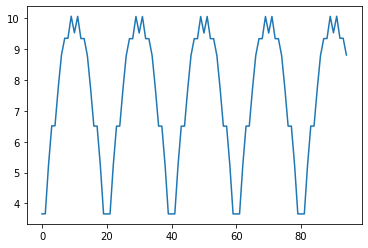

In [5]:
C = np.array([[12 * np.exp(-5.0 * abs(i-j)/50) for j in range(101)] for i in range(101)])  
obs_index = [0, 20, 40, 60, 80, 100]
depth = np.array([0, -4, -12.8, -1, -6.5, 0])
delta = 5
CSy = schur_n(C, obs_index)
mu = -5
E_cond = E_condi(C, obs_index, mu, depth)
print(E_cond)
plt.plot([i for i in range(len(CSy[0]))], [Var_condi(CSy, i, obs_index) for i in range(len(CSy[0]))])


"""à partir de tirage, on a un problème de positivité de la matrice, 
donc on prend C_ = np.identity(101) pour vérifier que ça marche"""
C_ = np.identity(101)
CSy_ = schur_n(C_, obs_index)
E_cond_ = E_condi(C, obs_index, mu, depth)

In [6]:
"""autre methode, étant donné qu'on n'obtient pas une matrice définie positive pour la première"""
def mat_permut(C, obs_index):
    L = [None for i in range(len(C))] ; j = 0 #j compte le nombre d'indices de obs_index déjà passés dans la boucle
    for i in range(len(C)): 
        if i in obs_index :
            L[i] = j + len(C)- len(obs_index)
            j += 1
        else : 
            L[i] = i-j
    M = np.array([[0 for j in range(len(C))] for i in range(len(C))])
    for i in range(len(C)):
        M[i][L[i]] = 1
    return M
mat_permut(np.identity(4), [1])
def extrac_o_o_new(Cpermut, obs_inde):
    return np.array([[Cpermut[i][j] for j in range(len(Cpermut)-len(obs_inde), len(Cpermut))]for i in range(len(Cpermut)-len(obs_inde), len(Cpermut))])
extrac_o_o_new(np.identity(3), [1, 2])
def extrac_n_n_new(Cpermut, obs_inde):
    return np.array([[Cpermut[i][j] for j in range(len(Cpermut))]for i in range(len(Cpermut))])
def extrac_o_n_new(Cpermut, obs_inde):
    return np.array([[Cpermut[i][j] for j in range(len(Cpermut))]for i in range(len(Cpermut)-len(obs_inde), len(Cpermut))])
def schur_n_new(C, obs_index):
    P = mat_permut(C, obs_index)
    Cpermut = np.linalg.multi_dot([P, C, np.linalg.inv(P)])
    C_z = extrac_o_o_new(Cpermut, obs_index)
    C_y = extrac_n_n_new(Cpermut, obs_index)
    C_zy = extrac_o_n_new(Cpermut, obs_index)
    return C_y - np.linalg.multi_dot([C_zy.T, np.linalg.inv(C_z), C_zy])

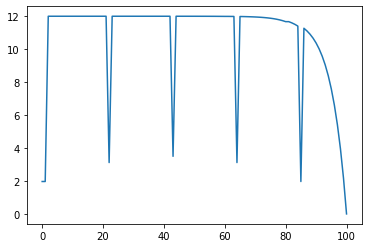

In [7]:
CSy_new = schur_n_new(C, obs_index)
plt.plot([i for i in range(len(CSy_new[0]))], [Var_condi(CSy_new, i, obs_index) for i in range(len(CSy_new[0]))])

En tracant, on observe la periodicité de la variance en fonction de i, variance qui parait tendre vers 0 à chaque fois que l'on s'approche des indices observables. C'est parfaitement logique : plus le point est proche d'un point observable, plus on pourra estimer précisément sa profondeur et donc plus l'étalement probabiliste, et donc la variance, sera faible. 

In [8]:

def tirage(C, obs_index, E):
    """ici on écrit le programme qui permet de simuler le tirage conditionnel, grace aux questions 2 et 3, 
    on utilise notamment le fait qu'un vecteur aux composantes normales centrées réduites est normal centré réduit"""
    CSy = schur_n(C, obs_index) # c'est la matrice de covariance de la loi conditionnelle
    R = np.linalg.cholesky(CSy)
    #simulation de la loi normale centrée réduite 
    U = np.array([rd.random() for i in range(len(C[0])-len(obs_index))])
    V = np.array([rd.random() for i in range(len(C[0])-len(obs_index))])
    norm = np.array([np.sqrt(-2 * np.log(U[i])) * np.cos(2 * np.pi * V[i]) for i in range(len(U))]) # le vecteur normal centré réduit
    return E + R.dot(norm) #qui suit bien une loi gaussienne d'espérance E et de matrice de covariance C
    

In [10]:

"""on trace ensuite l'altitude en fonction de x"""
Z_ = tirage(C_, obs_index, E_cond_)
print(Z_)
Z = tirage(C, obs_index, E_cond)
"""problème à régler ici, car avec cette forme de C, CSy n'est pas définie positive et on ne peut donc
pas lui appliquer la transformation de cholesky. En regardant les valeurs propres de la matrice C, on observe 
qu'elles sont toutes positives, et largement (souvent plus de 10), mais on a quelques vaps négatives (de l'ordre d'un dixième).
On peut soupconner un problème avec les calculs d'arrondi étant donné qu'on manipule des cacluls d'exp etc..."""
L = [z for z in Z]
print(L)
for i in range(len(obs_index)) : 
    L.insert(obs_index[i], depth[i])
plt.plot([delta * i for i in range(101)], L)

[ -1.21105783  -0.45645257  -1.97717365  -1.47447364  -0.71047897
  -3.67323278  -4.1036151   -2.41299235  -3.76703623  -3.56753718
  -1.42434978  -3.40791216  -1.65228436  -3.60781338  -4.261145
  -4.82133351  -2.62980766  -3.12369974  -4.80675734  -4.56866612
  -3.24464308  -4.03139297  -3.92871049  -5.97560405  -5.76754158
  -4.27682399  -7.05872349  -5.41729157  -7.3392291   -8.00754573
  -7.55365989  -9.54154627  -7.38046258  -9.55008674  -8.929953
  -8.70971493  -7.73516028 -11.55356796 -11.27442713 -11.7020737
  -7.11758134  -8.33379291  -9.2952143   -8.06168992  -8.68925
  -5.72712429  -5.53176723  -6.39003833  -5.5568182   -6.12293331
  -5.92437931  -2.90314744  -1.93593984  -1.82221745  -3.34328867
  -3.14862497  -2.37591099  -0.94846012  -2.12613546  -4.22318095
  -3.44290872  -2.17604063  -2.35019758  -0.8850933   -3.72033946
  -4.61362953  -3.00960561  -4.74999098  -4.90284513  -5.87578624
  -4.5250113   -6.18844739  -5.44515656  -4.42251493  -6.07380982
  -5.55982184  -6.

LinAlgError: Matrix is not positive definite

In [11]:
def longueur(Z, delt, obs_index, dept):
    """ici, on commence par créer le vecteur total à partir 
    du vecteur conditionnel simulé Z, qui ne décrit que les valeurs non observables obtenues sachant la valeur des observables."""
    l = 0 
    Z_ = [z for z in Z]
    for i in range(len(obs_index)) : 
        Z_.insert(obs_index[i], depth[i])
    for i in range(len(Z_) - 1) : #ensuite on calcule la longueur totale à partir du vecteur d'altitude total
        l += np.sqrt(delta ** 2 + (Z_[i+1] - Z_[i])**2)
    return l

def longueur_estimee(C, E, delt, obs_index, dept, n):
    """on fait une moyenne sur n valeurs"""
    liste_l = [longueur(tirage(C, obs_index, E), delt, obs_index, dept) for i in range(n)]
    s = 0
    for l in liste_l : 
        s+= l
    return s/n

520.4700918840985


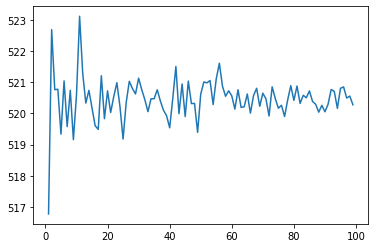

In [12]:
print(longueur_estimee(C_, E_cond_, delta, obs_index, depth, 100))
plt.plot([i for i in range(1, 100)], [longueur_estimee(C_, E_cond_, delta, obs_index, depth, i) for i in range(1, 100)])

On observe sans grande surprise que la suite Mn converge lorsque n tend vers $+\infty$ vers une valeur, qui est en réalité la longueur moyenne du cable. 

In [13]:
"""on doit trouver un intervalle encadrant la valeur du cable, tel que la probabilité qu'un tirage soit dans cet intervalle
soit d'au moins 95 %"""
def intervalle_conf_un(C, E_cond, delta, obs_index, depth, n = 100):
    """ici, on commence par estimer une moyenne, et ensuite on fait baisser diff pour que la probabilité pour
    un essai d'être dans [L-diff, L + diff] soit juste au-dessus de 0.95"""
    L = longueur_estimee(C, E_cond, delta, obs_index, depth, n)#ca serait la longueur moyenne
    def proba(diff):
        s = 0
        for i in range(n):
            if (L-diff <= longueur(tirage(C, obs_index, E_cond), delta, obs_index, depth) <= L+diff) : 
                s += 1
        return s/n
    diff = L #c'est l'essai d'intervalle de confiance initial
    while proba(diff) >= 0.95 : #tant que l'on n'est pas inclu dans l'intervalle de confiance
        diff/= 1.1
    return (L-diff*2, L+diff*2)

def intervalle_conf_deux(C, E_cond, delta, obs_index, depth, n = 100):
    """ici, on calcule directement l'intervalle de confiance avec une formule, après avoir estimé la moyenne ainsi que l'écart-type
    sur l'échantillon"""
    L = longueur_estimee(C, E_cond, delta, obs_index, depth, n)#moyenne
    V = 0
    for i in range(n):
        V += (longueur(tirage(C, obs_index, E_cond), delta, obs_index, depth) - L) **2
    sigma = np.sqrt(V/n)#ecart-type
    return (L - 1.96 * sigma/np.sqrt(n), L + 1.96 * sigma/np.sqrt(n))

def prob_depass(l_dep, C, E_cond, delta, obs_index, depth, n = 100):
    """ici, on fai juste n tirages et on regarde quelle proportion a dépassé 525, 
    on applique la loi des grands nombres à l'indicatrice de l>=525 et on obtient le résultat voulu"""
    s = 0
    for i in range(n):
        if l_dep <= longueur(tirage(C, obs_index, E_cond), delta, obs_index, depth) : 
            s += 1
    return s/n
    

In [14]:
print(intervalle_conf_un(C_, E_cond_, delta, obs_index, depth))
"""ce premier calcul d'intervalle de confiance est assez peu précise, et pour cause :
on réduit diff en le divisant à chaque fois par 1.1, ce qui est une forte diminution
pour des valeurs de l'ordre de la dizaine comme dans notre cas"""
print(intervalle_conf_deux(C_, E_cond_, delta, obs_index, depth))
print(prob_depass(525, C_, E_cond_, delta, obs_index, depth))
"""pour n=100 ou n=1000, il suffit de faire tourner ces programmes en changeant la valeur par défaut de n"""

(509.035400565078, 532.6572219690651)
(520.1580741688562, 521.3881415766883)
0.09
